# Introduction

# Exploratory data analysis

In [56]:
import pandas as pd 
import matplotlib.pyplot as plt 
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns
import numpy as np
import ipywidgets as ipw
from IPython.display import display

from textwrap import wrap

In [57]:
bls_work_stoppages_file_location = 'Dataset/work_stoppages_BLS.csv'  

def read_numeric_cell_with_commas(cell):
    try:
        return int(cell.replace(',',''))
    except:
        return 0

split_string_by_comma = lambda s: pd.Series(str(s).split(',')).map(lambda s_prime: s_prime.strip())

dtypes = {
    'Organizations involved': 'category',
    'Ownership': 'category',
    'Industry code[1]': 'category'
}

renamed_columns = {
    'Days idle, cumulative for this work stoppage[3]': 'Cumulative days idle',
    'Number of workers[2]': 'Number of workers',
    'Work stoppage beginning date': 'Beginning date',
    'Work stoppage ending date': 'Ending date',
    'Industry code[1]': 'Industry code'

}

column_converters = {
    'States': split_string_by_comma,
    'Union acronym': split_string_by_comma,
    'Days idle, cumulative for this work stoppage[3]': read_numeric_cell_with_commas, 
    'Number of workers[2]': read_numeric_cell_with_commas
}

other_columns_to_use = ['States', 'Union acronym']


bls_dataframe = pd.read_csv(bls_work_stoppages_file_location, 
    dtype=dtypes, 
    usecols=list(dtypes) + list(renamed_columns) + other_columns_to_use, 
    parse_dates=['Work stoppage beginning date','Work stoppage ending date'],
    converters=column_converters)

bls_dataframe = bls_dataframe.rename(columns=renamed_columns)

# Adding columns we'll want to play with later
bls_dataframe['Year'] = bls_dataframe['Beginning date'].map(lambda x: x.year)
bls_dataframe['Length (days)'] = bls_dataframe.apply(lambda x: (x['Ending date'] - x['Beginning date']).days, axis=1)

bls_dataframe.head()


,Organizations involved,States,Ownership,Industry code,Union acronym,Beginning date,Ending date,Number of workers,Cumulative days idle,Year,Length (days)
0,Association of National Advertisers; American ...,0 AR 1 MA 2 IL 3 OH 4 TX 5...,Private industry,54181,0 AFTRA 1 SAG dtype: object,2000-05-01,2000-10-30,135000,17280000,2000,182.0
1,"Albertsons, Ralphs, and Vons Markets",0 CA dtype: object,Private industry,445110,0 UFCW dtype: object,2003-10-12,2004-02-29,67300,5718100,2003,140.0
2,"Caterpillar, Inc.",0 IL 1 MI 2 PA 3 CO dtype: object,Private industry,3331,0 UAW dtype: object,1994-06-20,1995-12-03,14000,4063000,1994,531.0
3,General Motors Corp.,0 Interstate dtype: object,Private industry,3361,0 UAW dtype: object,1998-06-05,1998-07-29,152200,3313000,1998,54.0
4,Marine Towing and Transportation Employers' As...,0 NY dtype: object,Private industry,488330,0 ILA dtype: object,1988-02-16,1993-12-20,2500,2879500,1988,2134.0


In [58]:
# bls_dataframe = bls_dataframe[bls_dataframe['Cumulative days idle'] < 10000000]

In [59]:
# Some strikes affected more than one state at once; for example the Boeing strike of 2008 affected Washington, Oregon, and Kansas
# This is recorded in the CSV as a single row, with the States column saying "WA, OR, KS". If we want to do a groupby based on states, 
# we'll want to split (or 'explode') that into three mostly-identical rows, one for each state.
bls_dataframe_exploded_by_states = bls_dataframe.explode(column='States')

# Some strikes don't list a state, or simply say things like 'Interstate' or 'East coast states.' We can't use that to build choropleths,
# So we'll have to exclude these
bls_dataframe_exploded_by_states = bls_dataframe_exploded_by_states[bls_dataframe_exploded_by_states['States'].str.len() == 2]

bls_dataframe_exploded_by_states

,Organizations involved,States,Ownership,Industry code,Union acronym,Beginning date,Ending date,Number of workers,Cumulative days idle,Year,Length (days)
0,Association of National Advertisers; American ...,AR,Private industry,54181,0 AFTRA 1 SAG dtype: object,2000-05-01,2000-10-30,135000,17280000,2000,182.0
0,Association of National Advertisers; American ...,MA,Private industry,54181,0 AFTRA 1 SAG dtype: object,2000-05-01,2000-10-30,135000,17280000,2000,182.0
0,Association of National Advertisers; American ...,IL,Private industry,54181,0 AFTRA 1 SAG dtype: object,2000-05-01,2000-10-30,135000,17280000,2000,182.0
0,Association of National Advertisers; American ...,OH,Private industry,54181,0 AFTRA 1 SAG dtype: object,2000-05-01,2000-10-30,135000,17280000,2000,182.0
0,Association of National Advertisers; American ...,TX,Private industry,54181,0 AFTRA 1 SAG dtype: object,2000-05-01,2000-10-30,135000,17280000,2000,182.0
...,...,...,...,...,...,...,...,...,...,...,...
603,"Queen of the Valley Medical Center, Sutter Tra...",CA,Private industry,622110,0 CNA 1 NNU dtype: object,2014-08-14,2014-08-15,1000,1000,2014,1.0
604,"Port Authority of New York and New Jersey, New...",NY,Local government,488310,0 ILA dtype: object,2016-01-29,2016-01-29,1000,1000,2016,0.0
604,"Port Authority of New York and New Jersey, New...",NJ,Local government,488310,0 ILA dtype: object,2016-01-29,2016-01-29,1000,1000,2016,0.0
605,Charter Communications Inc.,NY,Private industry,517110,0 IBEW dtype: object,2017-03-28,NaT,1800,0,2017,NaN


C:\Users\emmaf\AppData\Local\Temp\ipykernel_26772\2966475981.py:42: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



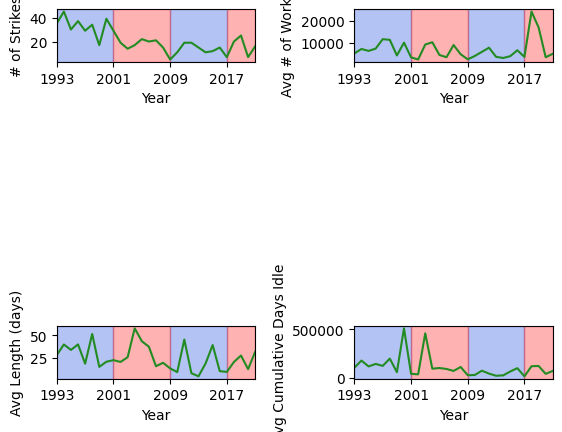

In [71]:

grouped_by_year = bls_dataframe[bls_dataframe['Year'] >= 1993].groupby(['Year']).agg({
    'Number of workers': ['sum', 'mean', 'count'],
    'Cumulative days idle': ['sum','mean'],
    'Length (days)': ['mean']
}).reset_index(names=['Year'])

grouped_by_year.columns = grouped_by_year.columns.map(' '.join)
grouped_by_year = grouped_by_year.rename(columns={'Year ' : 'Year', 'Number of workers count' : 'Number of strikes'})
grouped_by_year

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
# fig.set_figsize(10,5)

ax1.plot(grouped_by_year['Year'], grouped_by_year['Number of strikes'], color='forestgreen')
ax1.set_ylabel('# of Strikes')

ax2.plot(grouped_by_year['Year'], grouped_by_year['Number of workers mean'], color='forestgreen')
ax2.set_ylabel('Avg # of Workers')

ax3.plot(grouped_by_year['Year'], grouped_by_year['Length (days) mean'], color='forestgreen')
ax3.set_ylabel('Avg Length (days)')

ax4.plot(grouped_by_year['Year'], grouped_by_year['Cumulative days idle mean'], color='forestgreen')
ax4.set_ylabel('Avg Cumulative Days Idle')

axes = [ax1,ax2,ax3,ax4]
for ax in axes:
    ax.set_xlim([1993,2021])
    ax.set_xlabel('Year')
    
    ax.set_xticks([1993,2001,2009,2017])
    # years with a Democratic president are shaded in blue
    ax.axvspan(1993, 2001, alpha=0.4, color='royalblue')
    ax.axvspan(2009, 2017, alpha=0.4, color='royalblue')

    #years with a Republican president are shaded in red
    ax.axvspan(2001, 2009, alpha=0.3, color='red')
    ax.axvspan(2017, 2021, alpha=0.3, color='red')

fig.subplots_adjust(hspace=0.5, wspace=0.5)
# fig.tight_layout()
fig.show()

# Visualization 1

In [61]:


grouped_by_state = bls_dataframe_exploded_by_states.groupby('States').agg({
    'Number of workers': ['sum', 'mean', 'count'],
    'Cumulative days idle': ['sum','mean'],
    'Length (days)': ['mean']
}).reset_index(names=['States'])

grouped_by_state.columns = grouped_by_state.columns.map(' '.join)
grouped_by_state = grouped_by_state.rename(columns={'States ' : 'State', 'Number of workers count' : 'Number of strikes'})

grouped_by_state

,State,Number of workers sum,Number of workers mean,Number of strikes,Cumulative days idle sum,Cumulative days idle mean,Length (days) mean
0,AK,3900,1950.000000,2,12700,6.350000e+03,4.000000
1,AL,56900,4741.666667,12,1484000,1.236667e+05,51.727273
2,AR,137900,45966.666667,3,17320000,5.773333e+06,72.000000
3,AZ,91800,15300.000000,6,1058400,1.764000e+05,82.500000
4,CA,1101500,7596.551724,145,27450900,1.893166e+05,14.696552
5,CO,264900,18921.428571,14,22296100,1.592579e+06,71.428571
6,CT,109600,7306.666667,15,740500,4.936667e+04,14.066667
7,DC,246300,30787.500000,8,18494800,2.311850e+06,53.125000
8,DE,89300,29766.666667,3,982500,3.275000e+05,9.666667
9,FL,169600,24228.571429,7,17562200,2.508886e+06,49.428571


In [62]:
colorscale = px.colors.sequential.Inferno

fig1 = px.choropleth(grouped_by_state, 
    locations='State', 
    locationmode='USA-states', 
    color='Number of strikes', 
    hover_name='Number of strikes',
    color_continuous_scale=colorscale,
    scope='usa')

fig1.update_layout(title='Total Count')

fig2 = px.choropleth(grouped_by_state, 
    locations='State', 
    locationmode='USA-states', 
    color='Number of workers mean', 
    hover_name='State',
    color_continuous_scale=colorscale,
    scope='usa')


fig2.update_layout(title='Average Number of Workers')

fig3 = px.choropleth(grouped_by_state, #[grouped_by_state['Length (days) mean'] <= 365], 
    locations='State', 
    locationmode='USA-states', 
    color='Length (days) mean', 
    hover_name='Length (days) mean',
    color_continuous_scale=colorscale,
    scope='usa')

fig3.update_layout(title='Average Length (days)')

fig4 = px.choropleth(grouped_by_state, 
    locations='State', 
    locationmode='USA-states', 
    color='Cumulative days idle mean', 
    hover_name='Cumulative days idle mean',
    color_continuous_scale=colorscale,
    scope='usa')

fig4.update_layout(title='Average Cumulative days idle')

fig_subplots = ipw.VBox([
    ipw.HBox([go.FigureWidget(fig1),go.FigureWidget(fig2)]),
    ipw.HBox([go.FigureWidget(fig3),go.FigureWidget(fig4)])
])

display(ipw.HTML("<h2>Work Stoppages 1993-2021 by State</h2>"))
display(fig_subplots)

HTML(value='<h2>Work Stoppages 1993-2021 by State</h2>')

    'data': [{'coloraxis': 'coloraxis',
              'geo': 'geo…

In [63]:
colorscale = px.colors.sequential.Inferno

grouped_by_state_above_threshold = grouped_by_state[grouped_by_state['Number of strikes'] >= 10]

fig1 = px.choropleth(grouped_by_state_above_threshold, 
    locations='State', 
    locationmode='USA-states', 
    color='Number of strikes', 
    hover_name='Number of strikes',
    color_continuous_scale=colorscale,
    scope='usa')

fig1.update_layout(title='Total Count')

fig2 = px.choropleth(grouped_by_state_above_threshold, 
    locations='State', 
    locationmode='USA-states', 
    color='Number of workers mean', 
    hover_name='State',
    color_continuous_scale=colorscale,
    scope='usa')


fig2.update_layout(title='Average Number of Workers')

fig3 = px.choropleth(grouped_by_state_above_threshold, #[grouped_by_state['Length (days) mean'] <= 365], 
    locations='State', 
    locationmode='USA-states', 
    color='Length (days) mean', 
    hover_name='Length (days) mean',
    color_continuous_scale=colorscale,
    scope='usa')

fig3.update_layout(title='Average Length (days)')

fig4 = px.choropleth(grouped_by_state_above_threshold, 
    locations='State', 
    locationmode='USA-states', 
    color='Cumulative days idle mean', 
    hover_name='Cumulative days idle mean',
    color_continuous_scale=colorscale,
    scope='usa')

fig4.update_layout(title='Average Cumulative days idle')

fig_subplots = ipw.VBox([
    ipw.HBox([go.FigureWidget(fig1),go.FigureWidget(fig2)]),
    ipw.HBox([go.FigureWidget(fig3),go.FigureWidget(fig4)])
])

display(ipw.HTML("<h2>Work Stoppages 1993-2021 by State</h2>"))
display(fig_subplots)

HTML(value='<h2>Work Stoppages 1993-2021 by State</h2>')

    'data': [{'coloraxis': 'coloraxis',
              'geo': 'geo…

# Visualization 2

# Visualization 3